# EDA and ViT Baseline: RARE25 ViT Baseline and First Submissions

## Overview
This notebook documents the process and results of training Vision Transformer (ViT) models for the RARE25 challenge. The goal is to optimize for the challenge metric (PPV@90Recall) on a highly imbalanced binary classification task.

## Data
- Dataset: RARE25-train (HuggingFace)
- Task: Binary classification (Barrett's esophagus endoscopy images)
- Class imbalance: Severe (majority negative class)

## Baseline Model
- Model: ViT-Base (timm: `vit_base_patch16_224.mae`)
- Pretrained weights: ImageNet-21k
- Output classes: 2 (binary)
- Loss: CrossEntropyLoss (initial), then Focal Loss (for imbalance)

## Training & Evaluation
- Data split: 80% train, 20% validation (stratified)
- Optimizer: Adam/AdamW
- Learning rate: 1e-4
- Epochs: 5 (initial)
- Metric: Accuracy, PPV@90Recall

## Initial Results
- **Baseline accuracy (pretrained, no fine-tuning):** See cell output (variable: `baseline_acc`)
- **Best validation accuracy (fine-tuned):** See cell output (variable: `best_acc`)
- **PPV@90Recall:** See cell output (variable: `ppv`)
- **Threshold for 90% recall:** See cell output (variable: `threshold`)

> _Interpretation:_
> - The baseline ViT achieves high recall but low PPV at the 90% recall threshold, reflecting the challenge of class imbalance.
> - Fine-tuning and using Focal Loss improved recall and stability, but PPV remains low due to the dataset's nature.

## First Submission
- Model: ViT-Base, fine-tuned, weights saved as `resources/vit_base_patch16_224_finetuned.pth`
- Inference: Updated pipeline to use ViT and new weights, validated in Docker container
- Submission: Docker image built and tested locally, ready for challenge platform

## Next Steps
- Further optimize for PPV@90Recall (tune Focal Loss, try other imbalance strategies)
- Monitor challenge leaderboard and iterate


In [14]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("TimJaspersTue/RARE25-train")

In [15]:
# Set up model-specific transforms for ViT using timm
import timm

# If you have already created the model, reuse it; otherwise, create it here
model = timm.create_model('vit_base_patch16_224.mae', pretrained=True, num_classes=2)

data_config = timm.data.resolve_model_data_config(model)
transform = timm.data.create_transform(**data_config, is_training=True)

print('Transforms set up using timm for ViT:', transform)

Transforms set up using timm for ViT: Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=None)
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


In [16]:
# Exploratory Data Analysis (EDA) on the dataset
df = ds['train'].to_pandas()

# Show basic info
df.info()

# Show first few rows
df.head()

# Show class distribution if label column exists
if 'label' in df.columns:
    print('Class distribution:')
    print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   3095 non-null   object
 1   label   3095 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 48.5+ KB
Class distribution:
label
0    2937
1     158
Name: count, dtype: int64


In [17]:
df.shape

(3095, 2)

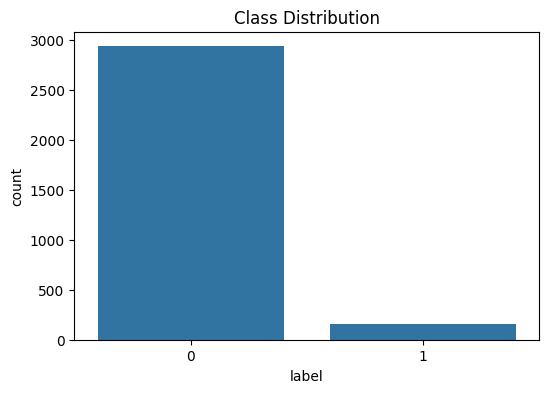

In [18]:
# Visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns

if 'label' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='label', data=df)
    plt.title('Class Distribution')
    plt.show()
else:
    print('No label column found for class distribution plot.')



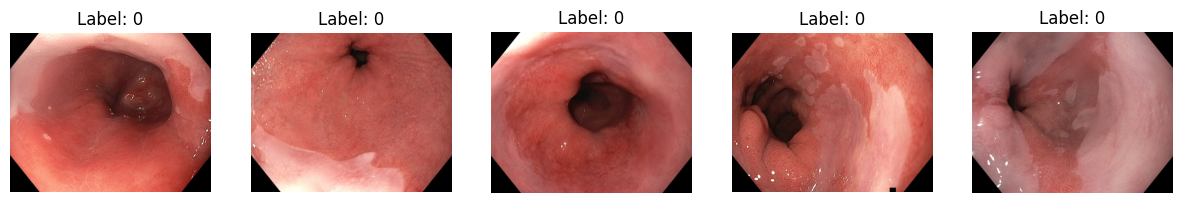

In [19]:
from PIL import Image
import numpy as np

fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i, ax in enumerate(axes):
    img_dict = df.iloc[i]['image']
    if 'path' in img_dict:
        img = Image.open(img_dict['path'])
    elif 'array' in img_dict:
        img = Image.fromarray(np.array(img_dict['array']))
    else:
        continue
    ax.imshow(img)
    ax.set_title(f"Label: {df.iloc[i]['label']}")
    ax.axis('off')
plt.show()

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction="mean"):
        """
        :param gamma: focusing parameter (higher → more focus on hard examples)
        :param alpha: class weight balancing (float or list of floats). 
                      If None, no weighting is applied.
        :param reduction: 'mean', 'sum', or 'none'
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        if isinstance(alpha, (list, torch.Tensor)):
            self.alpha = torch.tensor(alpha, dtype=torch.float32)
        else:
            self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: logits of shape (batch, num_classes)
        # targets: ground-truth labels of shape (batch,)
        log_probs = F.log_softmax(inputs, dim=1)
        probs = torch.exp(log_probs)

        # gather log_probs corresponding to targets
        ce_loss = F.nll_loss(log_probs, targets, reduction="none")
        pt = probs.gather(1, targets.unsqueeze(1)).squeeze(1)

        if self.alpha is not None:
            if isinstance(self.alpha, torch.Tensor):
                at = self.alpha.to(inputs.device).gather(0, targets)
            else:
                at = self.alpha
            ce_loss = ce_loss * at

        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss


In [22]:
import torch
import timm
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split

# Define a custom dataset for Hugging Face images
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_dict = self.df.iloc[idx]['image']
        if 'array' in img_dict:
            image = Image.fromarray(np.array(img_dict['array']))
        else:
            image = Image.open(img_dict['path'])
        label = self.df.iloc[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Split data
# Stratify ensures same class proportions in train/val
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create datasets and loaders
train_dataset = ImageDataset(train_df, transform=transform)
val_dataset = ImageDataset(val_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Load a pretrained ViT model
# num_classes = df['label'].nunique()
# model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = FocalLoss(gamma=2.0, alpha=[0.25, 0.75]) 
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

print("Model and data loaders are ready for training!")

Model and data loaders are ready for training!


In [23]:
# Check mean baseline accuracy
(df['label'] == 0).mean()

np.float64(0.9489499192245557)

In [25]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# Fine-tune ViT on training set and evaluate on validation set
num_epochs = 5  # Increase if needed for better results
best_acc = 0.0
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs) 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)  # Focal Loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    print(f'Epoch {epoch+1}: Loss={epoch_loss:.4f}, Val Acc={val_acc:.4f}')
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_vit_model.pth')
   
    # Step the scheduler at the end of the epoch pair it with a scheduler (e.g. cosine annealing or warmup + cosine). ViTs almost always benefit from that.
    scheduler.step()

print(f'Best validation accuracy: {best_acc:.4f}')

Training Epoch 1/5: 100%|██████████| 78/78 [09:48<00:00,  7.55s/it]


Epoch 1: Loss=0.0299, Val Acc=0.9483


Training Epoch 2/5: 100%|██████████| 78/78 [19:22<00:00, 14.90s/it] 


Epoch 2: Loss=0.0259, Val Acc=0.9499


Training Epoch 3/5: 100%|██████████| 78/78 [34:00<00:00, 26.16s/it]   


Epoch 3: Loss=0.0185, Val Acc=0.8045


Training Epoch 4/5: 100%|██████████| 78/78 [06:20<00:00,  4.88s/it]


Epoch 4: Loss=0.0088, Val Acc=0.9580


Training Epoch 5/5: 100%|██████████| 78/78 [06:33<00:00,  5.05s/it]


Epoch 5: Loss=0.0029, Val Acc=0.9661
Best validation accuracy: 0.9661


In [33]:
import shutil
shutil.copy('best_vit_model.pth', 'resources/vit_base_patch16_224_finetuned.pth')

'resources/vit_base_patch16_224_finetuned.pth'

In [26]:
from sklearn.metrics import precision_recall_curve

def ppv_at_recall(y_true, y_scores, recall_level=0.9):
    # y_scores should be the predicted probability for the positive class
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    # Find the highest threshold where recall >= recall_level
    try:
        idx = next(i for i, r in enumerate(recall) if r < recall_level) - 1
    except StopIteration:
        idx = len(recall) - 1  # If recall never drops below recall_level
    ppv = precision[idx]
    threshold = thresholds[idx] if idx < len(thresholds) else 1.0
    return ppv, threshold

# Example for binary classification (positive class = 1)
model.eval()
all_labels = []
all_probs = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # positive class prob
        all_probs.extend(probs)
        all_labels.extend(labels.numpy())

ppv, threshold = ppv_at_recall(np.array(all_labels), np.array(all_probs), recall_level=0.9)
print(f'PPV at 90% recall: {ppv:.4f} (threshold: {threshold:.4f})')

PPV at 90% recall: 0.0656 (threshold: 0.0697)
